# Scenario Theta

Scenario Theta is a synthetic stormwater system included in pystorms for prototyping control algorithms. This scenario is used in the pystorms paper to demonstrate the use of pystorms to evaluate the performance of control algorithms.

This notebook demonstrates the use of the equal-filling control algorithm for controlling outflows in the network. Please refer to the manuscript for more details of the approach. 

In [1]:
import pystorms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

### Generate Uncontrolled Baseline

In [2]:
# Run simulation with gates open
env_uncontrolled = pystorms.scenarios.theta()
done = False
while not done:
    done = env_uncontrolled.step()


 o  Retrieving project data

In [3]:
# convert flows as a dataframe for easy plotting and timeseries handling
uncontrolled_flows = pd.DataFrame.from_dict(env_uncontrolled.data_log["flow"])
uncontrolled_flows.index = env_uncontrolled.data_log["simulation_time"]
uncontrolled_flows = uncontrolled_flows.resample("15min").mean()
uncontrolled_flows = uncontrolled_flows.rename(columns={"8": "Uncontrolled"})

In [4]:
def controller(
    depths: np.ndarray,
    tolerance: float = 0.50,
    LAMBDA: float = 0.50,
    MAX_DEPTH: float = 2.0,
) -> np.ndarray:
    """
    Implementation of equal-filling controller

    Parameters
    ----------
    depths: np.ndarray
        depths in the basins being controlled
    tolerance: float
        parameter to control oscillations in the actions
    LAMBDA: float
        parameter for tuning controller's response
    MAX_DEPTH: float
        max depth in the basins to compute filling degree

    Returns
    -------
    actions: np.ndarray
        control actions
    """

    # Compute the filling degree
    f = depths / MAX_DEPTH

    # Estimate the average filling degree
    f_mean = np.mean(f)

    # Compute psi
    N = len(depths)
    psi = np.zeros(N)
    for i in range(0, N):
        psi[i] = f[i] - f_mean
        if psi[i] < 0.0 - tolerance:
            psi[i] = 0.0
        elif psi[i] >= 0.0 - tolerance and psi[i] <= 0.0 + tolerance:
            psi[i] = f_mean

    # Assign valve positions
    actions = np.zeros(N)
    for i in range(0, N):
        if depths[i] > 0.0:
            k = 1.0 / np.sqrt(2 * 9.81 * depths[i])
            action = k * LAMBDA * psi[i] / np.sum(psi)
            actions[i] = min(1.0, action)
    return actions


In [5]:
# Controlled simulation
env_controlled = pystorms.scenarios.theta()
done = False

while not done:
    state = env_controlled.state()
    # Note the difference between controlled and uncontrolled simulation
    actions = controller(state)
    done = env_controlled.step(actions)


 o  Retrieving project data

In [6]:
controlled_flows = pd.DataFrame.from_dict(env_controlled.data_log["flow"])
controlled_flows.index = env_controlled.data_log["simulation_time"]
controlled_flows = controlled_flows.resample("15min").mean()
controlled_flows = controlled_flows.rename(columns={"8": "Controlled"})

Text(0.5, 0, 'Time')

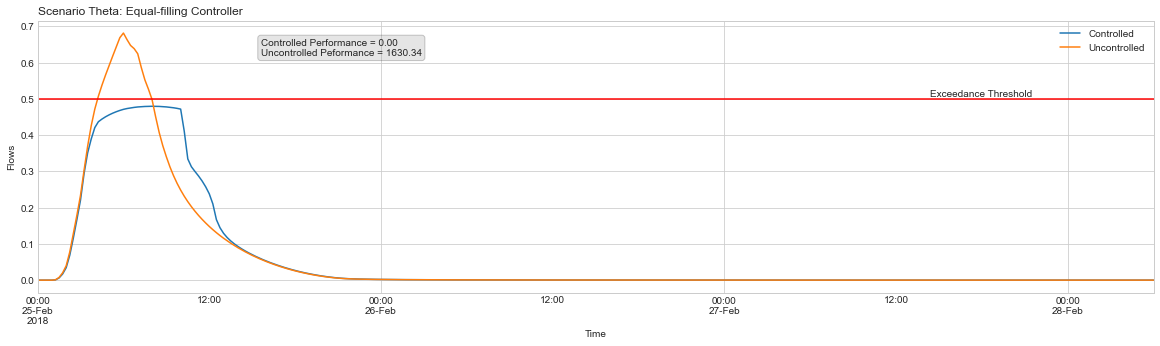

In [7]:
textstr = "Controlled Performance = {:.2f} \nUncontrolled Peformance = {:.2f}".format(
    env_controlled.performance(), env_uncontrolled.performance()
)

fig = plt.figure(num=1, figsize=(20, 5))
ax = plt.gca()
controlled_flows.plot(ax=ax)
uncontrolled_flows.plot(ax=ax)
ax.text(
    0.20,
    0.90,
    textstr,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="center",
    bbox=dict(boxstyle="round", facecolor="grey", alpha=0.2),
)
ax.text(
    0.80,
    0.73,
    "Exceedance Threshold",
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="center",
)
plt.axhline(y=0.50, color="red")
plt.title("Scenario Theta: Equal-filling Controller", loc="left")
plt.ylabel("Flows")
plt.xlabel("Time")